**Поля нашого датасету**
<ul>
    <li>Make - виробник</li>
    <li>Model - модель авто</li>
    <li>Type - тип кузова</li>
    <li>Origin - країна виробника</li>
    <li>DriveTrain - привод авто</li>
    <li>MSRP - рекомендована виробником ціна</li>
    <li>Invoice - ціна в автомобільних салонах</li>
    <li>EngineSize - об'єм двигуна</li>
    <li>Cylinders - кількість циліндрів (для ротерного -- '.')</li>
    <li>Horsepower - кінські сили</li>
    <li>Weight - вага автомобіля</li>
    <li>Wheelbase - відстань між колесами</li>
    <li>Length - довжина кузова</li>
    <li>MPG_City - витрати палива в місті</li>
    <li>MPG_Highway - витрати палива на трасі</li>
</ul>

**Мета -- передбачити витрати палива автомобіля в місті, відповідно до його технічних характеристик.**
<p>Для здійснення цього передбачення на основі заданих характеристик скористаємося задачею регресії.</p>
<p>Нашою метрикою буде mean_absolute_error, що є логічним, адже нам потрібно побачити реальне відхилення від нашого прогнозу.</p>

In [1]:
import pandas as pd
import math as m
import numpy as np

import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.linear_model import LinearRegression

In [2]:
random_state_const = 17

In [3]:
sns.set_context("notebook", font_scale = 0.8, rc = {"figure.figsize" : (20, 15), "axes.titlesize" : 10})

In [4]:
df = pd.read_csv('cars.csv', sep=';')

In [5]:
df = df.drop('Obs', axis=1)

In [6]:
df.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,"$36,945","$33,337",3.5,6,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$23,820","$21,761",2.0,4,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,"$26,990","$24,647",2.4,4,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,"$33,195","$30,299",3.2,6,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$43,755","$39,014",3.5,6,225,18,24,3880,115,197


In [7]:
df.shape

(428, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 15 columns):
Make           428 non-null object
Model          428 non-null object
Type           428 non-null object
Origin         428 non-null object
DriveTrain     428 non-null object
MSRP           428 non-null object
Invoice        428 non-null object
EngineSize     428 non-null float64
Cylinders      428 non-null object
Horsepower     428 non-null int64
MPG_City       428 non-null int64
MPG_Highway    428 non-null int64
Weight         428 non-null int64
Wheelbase      428 non-null int64
Length         428 non-null int64
dtypes: float64(1), int64(6), object(8)
memory usage: 50.2+ KB


Значна частина наших даних -- категоріальна. Але спершу спробуємо побудувати нашу модель на числових значеннях.

In [9]:
#позбудемося значка '$' в полях MSRP та Invoice
df['MSRP'] = df['MSRP'].map(lambda x: int(x[1:].replace(',', '')))
df['Invoice'] = df['Invoice'].map(lambda x: int(x[1:].replace(',', '')))

#для ротерного двигуна поставимо значення кількості циліндрів - 0
df['Cylinders'] = df['Cylinders'].map(lambda x: int(x.replace('.', '0')))

In [10]:
df.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945,33337,3.5,6,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820,21761,2.0,4,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,26990,24647,2.4,4,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,33195,30299,3.2,6,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755,39014,3.5,6,225,18,24,3880,115,197


In [11]:
df.describe()

,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,32774.855140,30014.700935,3.196729,5.780374,215.885514,20.060748,26.843458,3577.953271,108.154206,186.362150
std,19431.716674,17642.117750,1.108595,1.604557,71.836032,5.238218,5.741201,758.983215,8.311813,14.357991
min,10280.000000,9875.000000,1.300000,0.000000,73.000000,10.000000,12.000000,1850.000000,89.000000,143.000000
25%,20334.250000,18866.000000,2.375000,4.000000,165.000000,17.000000,24.000000,3104.000000,103.000000,178.000000
50%,27635.000000,25294.500000,3.000000,6.000000,210.000000,19.000000,26.000000,3474.500000,107.000000,187.000000
75%,39205.000000,35710.250000,3.900000,6.000000,255.000000,21.250000,29.000000,3977.750000,112.000000,194.000000
max,192465.000000,173560.000000,8.300000,12.000000,500.000000,60.000000,66.000000,7190.000000,144.000000,238.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 15 columns):
Make           428 non-null object
Model          428 non-null object
Type           428 non-null object
Origin         428 non-null object
DriveTrain     428 non-null object
MSRP           428 non-null int64
Invoice        428 non-null int64
EngineSize     428 non-null float64
Cylinders      428 non-null int64
Horsepower     428 non-null int64
MPG_City       428 non-null int64
MPG_Highway    428 non-null int64
Weight         428 non-null int64
Wheelbase      428 non-null int64
Length         428 non-null int64
dtypes: float64(1), int64(9), object(5)
memory usage: 50.2+ KB


In [13]:
#цільова змінна, яку будемо передбачати
y = df['MPG_City']

In [14]:
# зрозуміло, що залежість між витратами на трасі і в місці у автомобілів є. Перевіримо це. 
round(np.corrcoef(df['MPG_City'], df['MPG_Highway'])[0][1], 2) * 100

94.0

In [15]:
#оскільки кореляція між витратами палива є, то логічно, що потрібно видалити MPG_Highway, 
#а MPG_City -- видалити як цільову змінну
df = df.drop(['MPG_City', 'MPG_Highway'], axis=1)

In [16]:
#виберемо поля, що мають числові значення
num_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

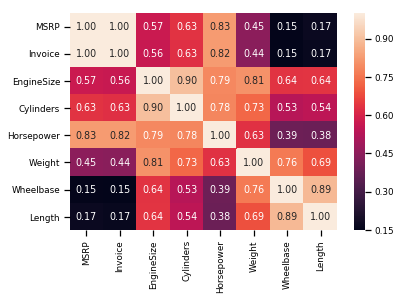

In [17]:
# подивимося на кореляцію числових полів
sns.heatmap(df[num_columns].corr(), annot=True, fmt='.2f');

бачимо очевидну залежність між 'MSRP' та 'Invoice', це випливає з опису вхідних даних. 
також бачимо залежність між Cylinders та EngineSize, а також між Length та Wheelbase.

також, видалимо Model, бо це хоч і категоріальне поле, але майже усі значення є унікальними.

In [18]:
df = df.drop(['MSRP', 'Length', 'Cylinders', 'Model'], axis=1)

In [19]:
num_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

In [20]:
df.head()

,Make,Type,Origin,DriveTrain,Invoice,EngineSize,Horsepower,Weight,Wheelbase
0,Acura,SUV,Asia,All,33337,3.5,265,4451,106
1,Acura,Sedan,Asia,Front,21761,2.0,200,2778,101
2,Acura,Sedan,Asia,Front,24647,2.4,200,3230,105
3,Acura,Sedan,Asia,Front,30299,3.2,270,3575,108
4,Acura,Sedan,Asia,Front,39014,3.5,225,3880,115


In [21]:
#оголошуємо нашу модель з якою будемо далі працювати.
ligreg = LinearRegression()

In [22]:
#оскільки дані має дещо різні то потрібно дещо стандартизувати дані.
scaler = StandardScaler()
df_std = scaler.fit_transform(df[num_columns])

#розділимо наші дані на тренувальні і тестові, на яких будемо перевіряти нашу модель
X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.3, random_state=random_state_const)


print(-np.mean(cross_val_score(ligreg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')))

1.6325541005903503


In [23]:
#потренуємо нашу модель на тренувальних даних, що ми раніше визначили як тренувальні
ligreg = LinearRegression()
ligreg.fit(X_train, y_train)
list(zip(ligreg.coef_, num_columns))

[(0.5792679578844728, 'Invoice'),
 (-0.5074255659868795, 'EngineSize'),
 (-1.9515999480400092, 'Horsepower'),
 (-2.5396984775439684, 'Weight'),
 (0.4797634109609165, 'Wheelbase')]

In [24]:
#передбачемо наші дані на тестовій вибірці
y_pred = ligreg.predict(X_test)

In [25]:
#перевіримо точність нашої моделі
metrics.mean_absolute_error(y_pred, y_test)

2.054069377227348